In [1]:
import sys
sys.path.append("../scripts")
sys.path.append("../datasets")


In [2]:
from cargar_dataset import cargar_dataset
from config_datasets import config_datasets
from evaluacion import evaluar_sampler_holdout
from custom_samplers import PCSMOTEWrapper

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    f1_score, balanced_accuracy_score,
    matthews_corrcoef, cohen_kappa_score
)
from sklearn.preprocessing import LabelEncoder
from pc_smote import PCSMOTE
from sklearn.model_selection import StratifiedKFold


In [3]:
from sklearn.model_selection import StratifiedKFold

def evaluar_pcsmote_grid_search(nombre_dataset, config, percentiles_densidad, percentiles_riesgo, criterios_pureza, modelo_clasificador, nombre_modelo):
    print(f"📂 Cargando dataset: {nombre_dataset}")
    X, y, _ = cargar_dataset(
        path=config["path"],
        clase_minoria=config.get("clase_minoria"),
        col_features=config.get("col_features"),
        col_target=config.get("col_target"),
        sep=config.get("sep", ","),
        header=config.get("header", None),
        binarizar=False,
        tipo=config.get("tipo", "tabular")
    )

    if y.dtype == object or isinstance(y[0], str):
        y = LabelEncoder().fit_transform(y)

    if config.get("tipo") == "imagen":
        X = X.reshape((X.shape[0], -1)).astype(np.float32)

    clases_minor = config.get("clases_minor", [])

    resultados = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for pdens in percentiles_densidad:
        for priesgo in percentiles_riesgo:
            for criterio in criterios_pureza:
                print(f"🧪 {nombre_modelo} | {nombre_dataset} | Densidad: {pdens} | Riesgo: {priesgo} | Pureza: {criterio}")
                metricas_fold = []

                for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
                    print(f"🔁 Fold {fold_idx + 1}/5 - Iniciando...")

                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    n_components = min(X_train.shape[0], X_train.shape[1], 100)
                    pca = PCA(n_components=n_components)
                    X_train_pca = pca.fit_transform(X_train)
                    X_test_pca = pca.transform(X_test)

                    sampler = PCSMOTE(
                        random_state=42,
                        percentil_densidad=pdens,
                        percentil_dist=priesgo,
                        criterio_pureza=criterio,
                        modo_espacial='3d'
                    )

                    try:
                        if hasattr(sampler, "fit_resample_multiclass"):
                            X_res, y_res = sampler.fit_resample_multiclass(X_train_pca, y_train)
                        else:
                            X_res, y_res = sampler.fit_resample(X_train_pca, y_train)

                        modelo_clasificador.fit(X_res, y_res)
                        y_pred = modelo_clasificador.predict(X_test_pca)

                        f1_macro = f1_score(y_test, y_pred, average='macro')
                        balanced_acc = balanced_accuracy_score(y_test, y_pred)
                        mcc = matthews_corrcoef(y_test, y_pred)
                        kappa = cohen_kappa_score(y_test, y_pred)

                        f1_minor = None
                        if clases_minor:
                            mask = np.isin(y_test, clases_minor)
                            if np.any(mask):
                                f1_minor = f1_score(y_test[mask], y_pred[mask], average='macro')
                                print(f"📊 Evaluando f1_minor sobre {np.sum(mask)} muestras de clases minoritarias en el test.")
                                print("✔️ Clases verdaderas:", y_test[mask])
                                print("❌ Clases predichas:", y_pred[mask])


                        metricas_fold.append({
                            'f1_score_macro': f1_macro,
                            'f1_score_minor': f1_minor,
                            'balanced_accuracy': balanced_acc,
                            'mcc': mcc,
                            'cohen_kappa': kappa
                        })

                        if f1_minor is not None:
                            print(f"✅ Fold {fold_idx + 1} finalizado | F1_macro: {f1_macro:.4f}, F1_minor: {f1_minor:.4f}")
                        else:
                            print(f"✅ Fold {fold_idx + 1} finalizado | F1_macro: {f1_macro:.4f}")

                    except Exception as e:
                        print(f"⚠️ Error en fold {fold_idx + 1}: {e}")
                        metricas_fold.append({
                            'f1_score_macro': None,
                            'f1_score_minor': None,
                            'balanced_accuracy': None,
                            'mcc': None,
                            'cohen_kappa': None,
                            'error': str(e)
                        })

                df_metricas = pd.DataFrame(metricas_fold)
                df_mean = df_metricas.dropna().mean(numeric_only=True).to_dict()
                df_mean.update({
                    'dataset': nombre_dataset,
                    'modelo': nombre_modelo,
                    'densidad': pdens,
                    'riesgo': priesgo,
                    'pureza': criterio
                })

                resultados.append(df_mean)

    df = pd.DataFrame(resultados)
    df.to_csv(f"../resultados/pcsmote_grid_{nombre_dataset}_{nombre_modelo}.csv", index=False)
    print(f"📁 Resultados guardados en: ../resultados/pcsmote_grid_{nombre_dataset}_{nombre_modelo}.csv")


In [4]:

def evaluar_otra_tecnica_grid(nombre_dataset, config, tecnica, modelo_clasificador, nombre_modelo, nombre_tec):
    print(f"📂 Cargando dataset: {nombre_dataset}")
    X, y, _ = cargar_dataset(
        path=config["path"],
        clase_minoria=config.get("clase_minoria"),
        col_features=config.get("col_features"),
        col_target=config.get("col_target"),
        sep=config.get("sep", ","),
        header=config.get("header", None),
        binarizar=False,
        tipo=config.get("tipo", "tabular")
    )

    if y.dtype == object or isinstance(y[0], str):
        y = LabelEncoder().fit_transform(y)

    if config.get("tipo") == "imagen":
        X = X.reshape((X.shape[0], -1)).astype(np.float32)

    clases_minor = config.get("clases_minor", [])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metricas_fold = []

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"🔁 Fold {fold_idx + 1}/5")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pca = PCA(n_components=min(X_train.shape[1], 100))
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        try:
            if tecnica:
                X_res, y_res = tecnica.fit_resample(X_train_pca, y_train)
            else:
                X_res, y_res = X_train_pca, y_train

            modelo_clasificador.fit(X_res, y_res)
            y_pred = modelo_clasificador.predict(X_test_pca)

            f1_macro = f1_score(y_test, y_pred, average='macro')
            balanced_acc = balanced_accuracy_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            kappa = cohen_kappa_score(y_test, y_pred)

            f1_minor = None
            if clases_minor:
                mask = np.isin(y_test, clases_minor)
                if np.any(mask):
                    f1_minor = f1_score(y_test[mask], y_pred[mask], average='macro')

            metricas_fold.append({
                'f1_score_macro': f1_macro,
                'f1_score_minor': f1_minor,
                'balanced_accuracy': balanced_acc,
                'mcc': mcc,
                'cohen_kappa': kappa
            })

        except Exception as e:
            print(f"⚠️ Error en fold {fold_idx + 1}: {e}")
            metricas_fold.append({
                'f1_score_macro': None,
                'f1_score_minor': None,
                'balanced_accuracy': None,
                'mcc': None,
                'cohen_kappa': None,
                'error': str(e)
            })

    # Calcular promedios ignorando errores
    df_metricas = pd.DataFrame(metricas_fold)
    df_mean = df_metricas.dropna().mean(numeric_only=True).to_dict()
    df_mean.update({
        'dataset': nombre_dataset,
        'modelo': nombre_modelo,
        'tecnica': nombre_tec
    })

    df_final = pd.DataFrame([df_mean])
    df_final.to_csv(f"../resultados/{nombre_tec}_grid_{nombre_dataset}_{nombre_modelo}.csv", index=False)
    print(f"📁 Resultados guardados en: ../resultados/{nombre_tec}_grid_{nombre_dataset}_{nombre_modelo}.csv")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from config_datasets import config_datasets
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

tecnicas_sobremuestreo = {
    "base": None,
    "pcsmote": PCSMOTE(
        random_state=42,
        percentil_densidad=50,  # serán reemplazados dinámicamente en el grid
        percentil_dist=50,
        criterio_pureza='entropia',
        modo_espacial='3d',
        verbose=False
    ),
    "smote": SMOTE(random_state=42),
    "adasyn": ADASYN(random_state=42),
    "borderline": BorderlineSMOTE(random_state=42)
}

modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(random_state=42)
    # "XGBoost": XGBClassifier(...)  // esta fallando por la etiquetas
}

percentiles_densidad = [25, 50, 75]
percentiles_riesgo = [25, 50, 75]
criterios_pureza = ["entropia", "proporcion"]

for nombre_dataset, config in config_datasets.items():
    if nombre_dataset == "eurosat":
        continue

    if nombre_dataset == "shuttle":
        for nombre_modelo, modelo in modelos.items():
            for nombre_tec, tecnica in tecnicas_sobremuestreo.items():
                print(f"\n=== Ejecutando grid para {nombre_dataset} | modelo: {nombre_modelo} | técnica: {nombre_tec} ===")

                if nombre_tec == "pcsmote":
                    evaluar_pcsmote_grid_search(
                        nombre_dataset, config,
                        percentiles_densidad, percentiles_riesgo,
                        criterios_pureza, modelo, nombre_modelo
                    )
                else:
                    evaluar_otra_tecnica_grid(
                        nombre_dataset, config, tecnica,
                        modelo, nombre_modelo, nombre_tec
                    )


=== Ejecutando grid para shuttle | modelo: RandomForest | técnica: base ===
📂 Cargando dataset: shuttle
🔁 Fold 1/5
🔁 Fold 2/5
🔁 Fold 3/5
🔁 Fold 4/5
🔁 Fold 5/5
📁 Resultados guardados en: ../resultados/base_grid_shuttle_RandomForest.csv

=== Ejecutando grid para shuttle | modelo: RandomForest | técnica: pcsmote ===
📂 Cargando dataset: shuttle
🧪 RandomForest | shuttle | Densidad: 25 | Riesgo: 25 | Pureza: entropia
🔁 Fold 1/5 - Iniciando...
📌 Total muestras minoritarias: 40
📌 Total muestras mayoritarias: 46360
📌 Total muestras minoritarias: 137
📌 Total muestras mayoritarias: 46263
📌 Total muestras minoritarias: 7122
📌 Total muestras mayoritarias: 39278
📌 Total muestras minoritarias: 2613
📌 Total muestras mayoritarias: 43787
📌 Total muestras minoritarias: 8
📌 Total muestras mayoritarias: 46392
📌 Total muestras minoritarias: 11
📌 Total muestras mayoritarias: 46389
📊 Evaluando f1_minor sobre 14 muestras de clases minoritarias en el test.
✔️ Clases verdaderas: [7 6 2 2 2 2 7 2 2 2 2 2 6 2]
❌ 

In [ ]:
import pandas as pd
import os
import glob

datasets = ['shuttle']
tecnicas = ['base', 'smote', 'adasyn', 'borderline', 'pcsmote']
modelos = ['RandomForest', 'LogisticRegression', 'SVM']

resumen = []

for dataset in datasets:
    for tecnica in tecnicas:
        archivos = glob.glob(f"../resultados/{tecnica}_grid_{dataset}_*.csv")
        if not archivos:
            print(f"⚠️ No hay resultados para {dataset} con técnica {tecnica}")
            continue

        mejores_filas = []

        for archivo in archivos:
            try:
                df = pd.read_csv(archivo)
                df_valid = df.dropna(subset=["f1_score"])
                if df_valid.empty:
                    continue

                fila = df_valid.sort_values(by="f1_score", ascending=False).iloc[0].copy()
                fila['dataset'] = dataset
                fila['tecnica'] = tecnica

                nombre_archivo = os.path.basename(archivo)
                modelo_detectado = next((m for m in modelos if m in nombre_archivo), "desconocido")
                fila['modelo'] = modelo_detectado

                mejores_filas.append(fila)

            except Exception as e:
                print(f"⚠️ Error procesando {archivo}: {e}")


        # Guardar el mejor resultado por técnica
        if mejores_filas:
            mejor = pd.DataFrame(mejores_filas).sort_values(by="f1_score", ascending=False).iloc[0]
            resumen.append(mejor)

# Crear DataFrame final
resumen_df = pd.DataFrame(resumen)

# Reordenar columnas según disponibilidad
cols = ['dataset', 'tecnica', 'modelo', 'f1_score']
for col in ['balanced_accuracy', 'mcc', 'cohen_kappa', 'densidad', 'riesgo', 'pureza','error']:
    if col in resumen_df.columns:
        cols.append(col)

resumen_df = resumen_df[cols]
resumen_df.to_csv("../resultados/resumen_mejores_por_tecnica.csv", index=False)
print("✅ Resumen guardado en ../resultados/resumen_mejores_por_tecnica.csv")


✅ Resumen guardado en ../resultados/resumen_mejores_por_tecnica.csv


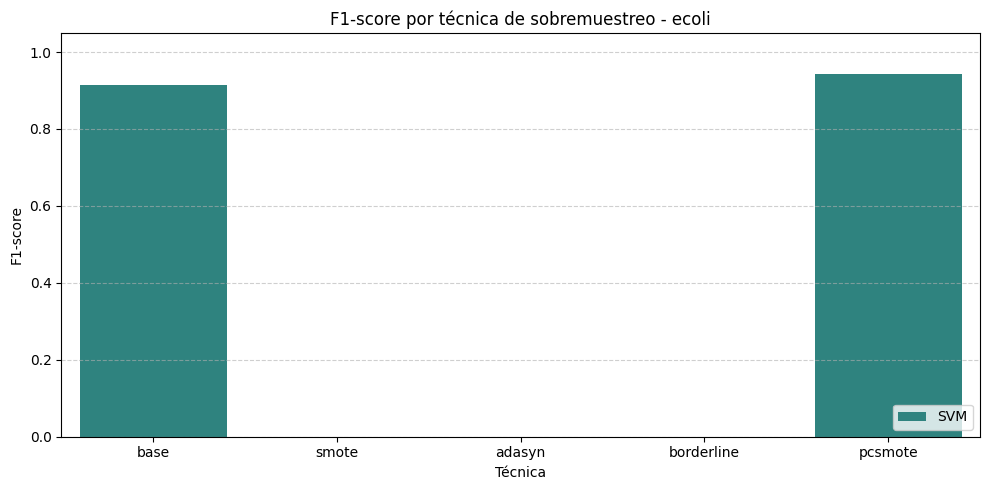

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el resumen
df = pd.read_csv("../resultados/resumen_mejores_por_tecnica.csv")

# Ajustar orden de técnicas para mejor visualización
orden_tecnicas = ['base', 'smote', 'adasyn', 'borderline', 'pcsmote']
df['tecnica'] = pd.Categorical(df['tecnica'], categories=orden_tecnicas, ordered=True)

# Plot por dataset
for dataset in df['dataset'].unique():
    plt.figure(figsize=(10, 5))
    df_sub = df[df['dataset'] == dataset].sort_values("tecnica")

    sns.barplot(
        data=df_sub,
        x="tecnica",
        y="f1_score",
        hue="modelo",  # opcional: para ver qué modelo dio ese resultado
        dodge=False,
        palette="viridis"
    )

    plt.title(f"F1-score por técnica de sobremuestreo - {dataset}")
    plt.ylabel("F1-score")
    plt.ylim(0, 1.05)
    plt.xlabel("Técnica")
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.legend(loc="lower right")
    plt.show()
